# **SpaceX  Falcon 9: Landing Prediction**

# Exploring the data

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load the data
df = pd.read_csv('Launch_Data.csv')
df.head()

,FlightNumber,Date,Booster,PayloadMass,Orbit,Site,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,NaN,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,NaN,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,NaN,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,NaN,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857


In [3]:
# How many different Boosters are there
df['Booster'].value_counts()

Falcon 9    168
Falcon 1      4
Name: Booster, dtype: int64

Lets focus on Falcon 9 boosters since they make up the majority of the data frame. 

In [4]:
df=df[df['Booster']=='Falcon 9']
df['Booster'].value_counts()

Falcon 9    168
Name: Booster, dtype: int64

In [5]:
df['FlightNumber'].tail()

167    181
168    182
169    185
170    186
171    187
Name: FlightNumber, dtype: int64

In [6]:
# To maintain the number of flights and the the flight number consistency now that we've removed some flights, lets updae the flight number to match with the number of flights in the dataset
df.loc[:,'FlightNumber'] = list(range(1, df.shape[0]+1))
df['FlightNumber'].tail()

167    164
168    165
169    166
170    167
171    168
Name: FlightNumber, dtype: int64

## Data Wrangling

In [7]:
# Identify any Missing Values
df.isnull().sum()

FlightNumber     0
Date             0
Booster          0
PayloadMass     22
Orbit            1
Site             0
Outcome          0
Flights          0
GridFins         0
Reused           0
Legs             0
LandingPad      26
Block            0
ReusedCount      0
Serial           0
Longitude        0
Latitude         0
dtype: int64

The only null values are in the Orbit column, PayloadMass column and the LandingPad column. The nulls in the Landing Pad column makes sense becuase not all launches need or use landing pads during their landing. But the null Payload mass values will not be helpful for our numeric analysis. I can drop the 22 launches, but that would be a significant loss. I could also change the null Payload Mass values to 0, but that would skew the mass. I'll replace the null values with the mean, to maintain the data distribution. 

In [8]:
payload_mean=df['PayloadMass'].mean()
# Replace the np.nan values with its mean value
df['PayloadMass'] = df['PayloadMass'].replace(np.nan, payload_mean)
df.isnull().sum()

FlightNumber     0
Date             0
Booster          0
PayloadMass      0
Orbit            1
Site             0
Outcome          0
Flights          0
GridFins         0
Reused           0
Legs             0
LandingPad      26
Block            0
ReusedCount      0
Serial           0
Longitude        0
Latitude         0
dtype: int64

In [9]:
df[df['Orbit'].isna()]

,FlightNumber,Date,Booster,PayloadMass,Orbit,Site,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
99,96,2020-12-19,Falcon 9,8191.07911,NaN,KSC LC 39A,True RTLS,5,True,True,True,5e9e3032383ecb267a34e7c7,5.0,5,B1059,-80.603956,28.608058


In [10]:
# Apply value_counts on Orbit column
df['Orbit'].value_counts()

VLEO     54
ISS      32
GTO      31
LEO      14
PO       13
SSO      11
MEO       5
GEO       2
TLI       2
ES-L1     1
HEO       1
SO        1
Name: Orbit, dtype: int64

Looks like the null Orbit may have been an oversite as the outcome of the landing was successful. We will keep it in for now but may consider replacing it with an a mode value for the launches of the <code>KSC LC 39A</code> sight

In [11]:
# Lets look at the different types of landing outcomes
df['Outcome'].value_counts()

True ASDS      109
True RTLS       23
None None       19
False ASDS       7
True Ocean       5
False Ocean      2
None ASDS        2
False RTLS       1
Name: Outcome, dtype: int64

The format of the Outcome is indicating whether the rocket landed where it expected (T/F) or if it didn't land (None), and then where it supposed to landed (ASDS,RTLS,Ocean,None).
To simplify it, I consider a successful mission as an landing outcome starting with True and unsuccessful mission as a landing outcome non starting with True. 
Lets create a boolean column with the simplified outcome (0 for unsuccessful, 1 for successful).

In [12]:
df['MissionSuccess'] = 1
for i in range(0, df.shape[0]):
    first5 = str(df.iloc[i,6])[0:5]
    if first5 == 'False' or first5=='None ':
        df.iloc[i,17]=0
df['MissionSuccess'].value_counts()

1    137
0     31
Name: MissionSuccess, dtype: int64

In [13]:
# Data types of our dataframe
df.dtypes

FlightNumber        int64
Date               object
Booster            object
PayloadMass       float64
Orbit              object
Site               object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
MissionSuccess      int64
dtype: object

Lets look at the launch sites to see how many of the launches initiated from each launch site

In [14]:
df['Site'].value_counts()

CCSFS SLC 40    93
KSC LC 39A      49
VAFB SLC 4E     26
Name: Site, dtype: int64

## Visualizations of the data

Now that `FlightNumber` is continuous and `Payload Mass` variable has no nulls, lets see how these values would affect the launch outcome.

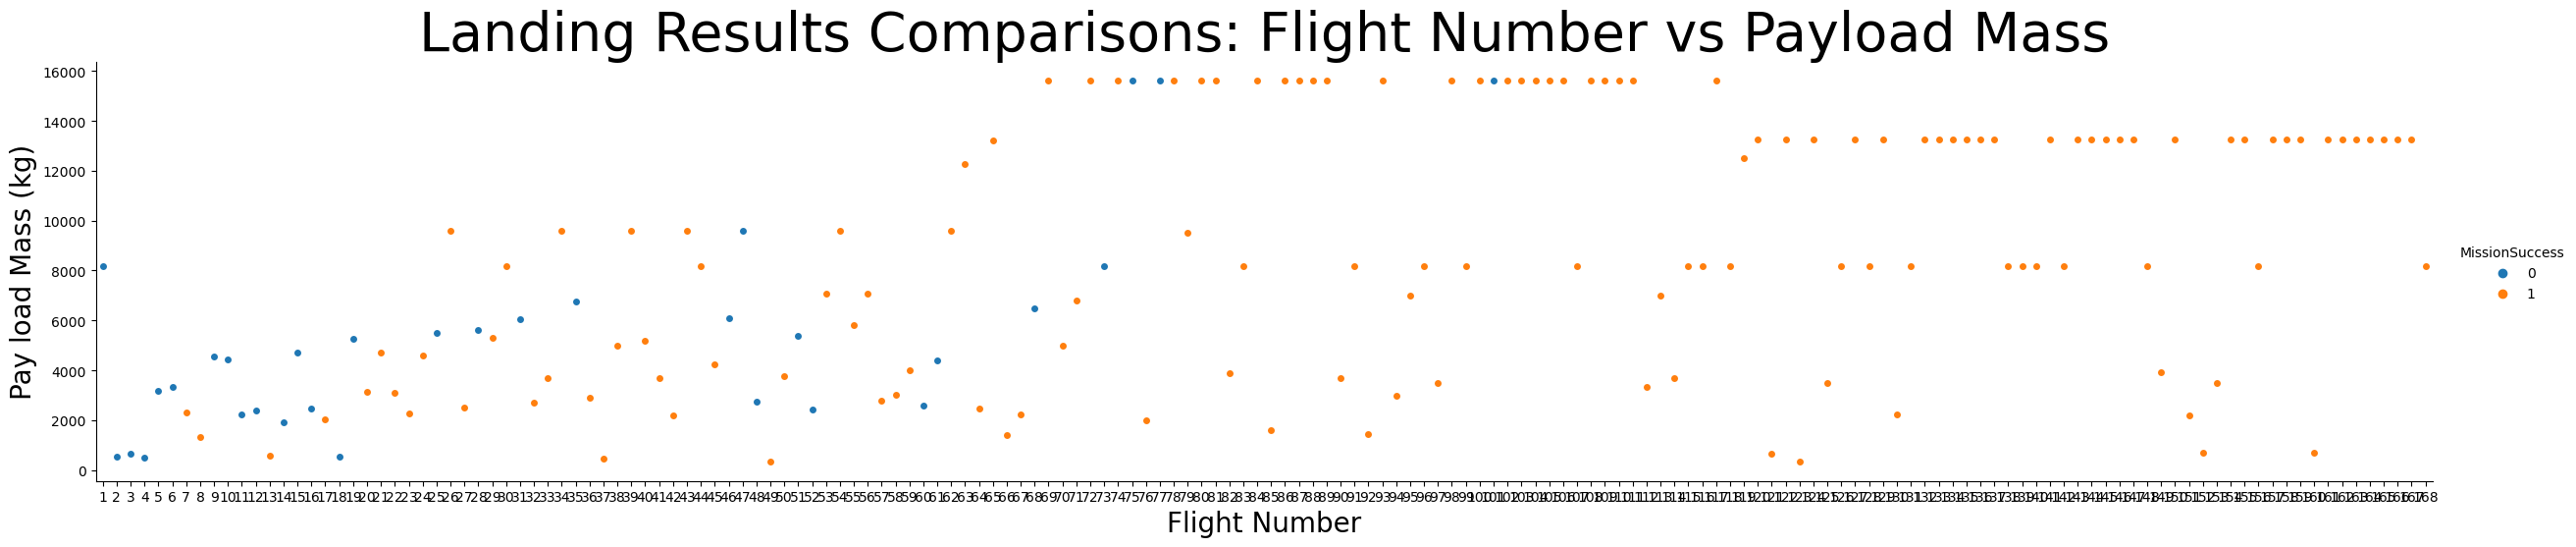

In [15]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="MissionSuccess", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.title("Landing Results Comparisons: Flight Number vs Payload Mass", fontsize=40)
plt.show()

It seems that the early flights had a much lower success rate then the later flights, regardless of Payload mass. 

Lets look at the Mission Success Rate by Launch Site.

In [16]:
df.groupby('Site')['MissionSuccess'].mean()

Site
CCSFS SLC 40    0.752688
KSC LC 39A      0.897959
VAFB SLC 4E     0.884615
Name: MissionSuccess, dtype: float64

The launch site with the highest Mission Success rate of 89.8% is <code>KSC LC 39A</code> (Kennedy Space Center). Lets look at the relationship between flight number and Launch site.

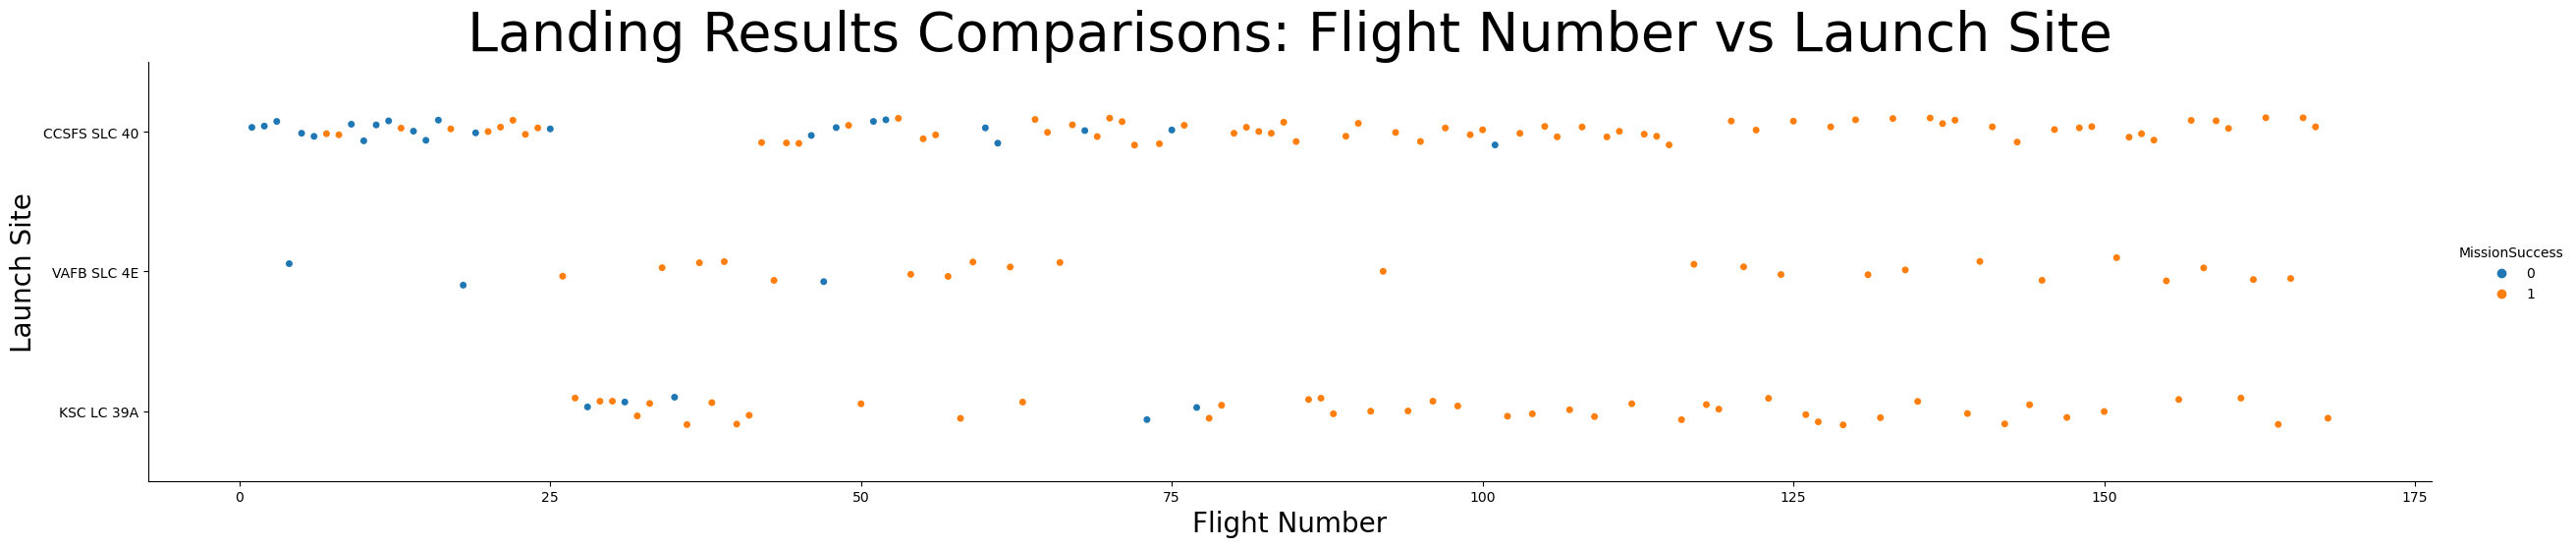

In [17]:

sns.catplot(data=df, x='FlightNumber', y='Site', hue='MissionSuccess', aspect=5)
plt.xlabel('Flight Number', fontsize=20)
plt.ylabel('Launch Site', fontsize=20)
plt.title ('Landing Results Comparisons: Flight Number vs Launch Site', fontsize=40)
plt.show()


The Kennedy Space Center Success Rate is due to the small number of failures in the first set of launches from that sighta nd the high frequency of (successful) missions in comparison to <code>VAFB SLC 4E</code> which had less failures then <code>KSC LC 39A</code>.  Lets look at other possible reasons why KSC had more successful runs early on. Lets start with comparison of Payload Mass per Launch Site.

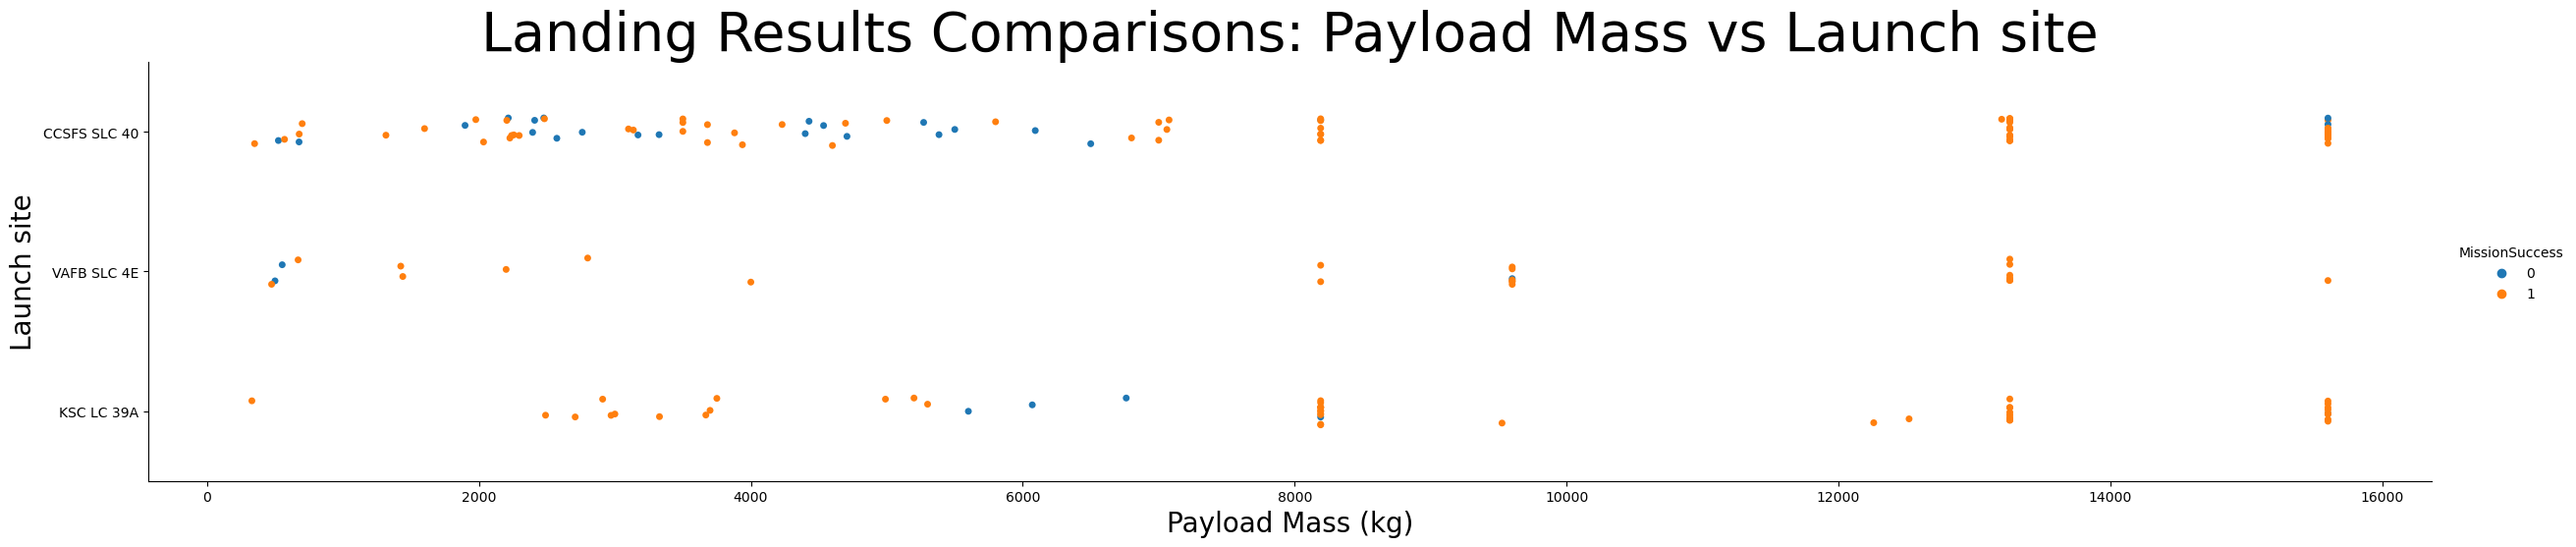

In [18]:

sns.catplot(data=df, x='PayloadMass',y='Site', hue='MissionSuccess', aspect=5)
plt.ylabel("Launch site",fontsize=20)
plt.xlabel("Payload Mass (kg)",fontsize=20)
plt.title("Landing Results Comparisons: Payload Mass vs Launch site", fontsize=40)
plt.show()

Another property of Luanches is the route/orbit it takes. Lets look at that in comparison to mission successes and failures

Text(0.5, 1.0, 'Success rate by Orbit type')

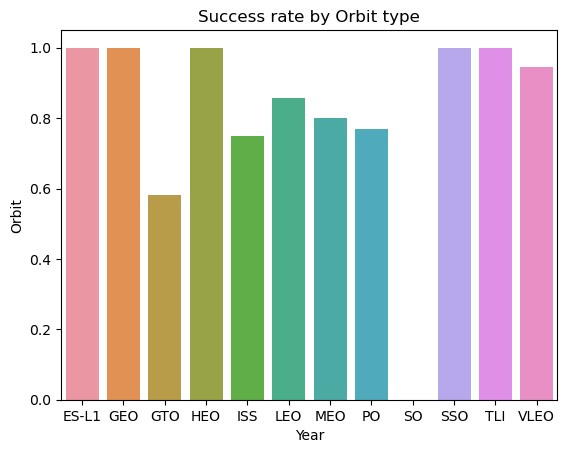

In [20]:
df_Orbit = df.groupby('Orbit').agg(mean_class=('MissionSuccess', 'mean'))
df_Orbit = df_Orbit.reset_index()
  
# plot barplot
sns.barplot(data=df_Orbit, x='Orbit', y='mean_class')
plt.xlabel('Year')
plt.ylabel('Orbit')
plt.title('Success rate by Orbit type')

A few of the orbits (ES-L1, GEO, HEO, SSO, TLI, VLEO) have 100% Mission Success rate, while SO orbit has not been successful at all

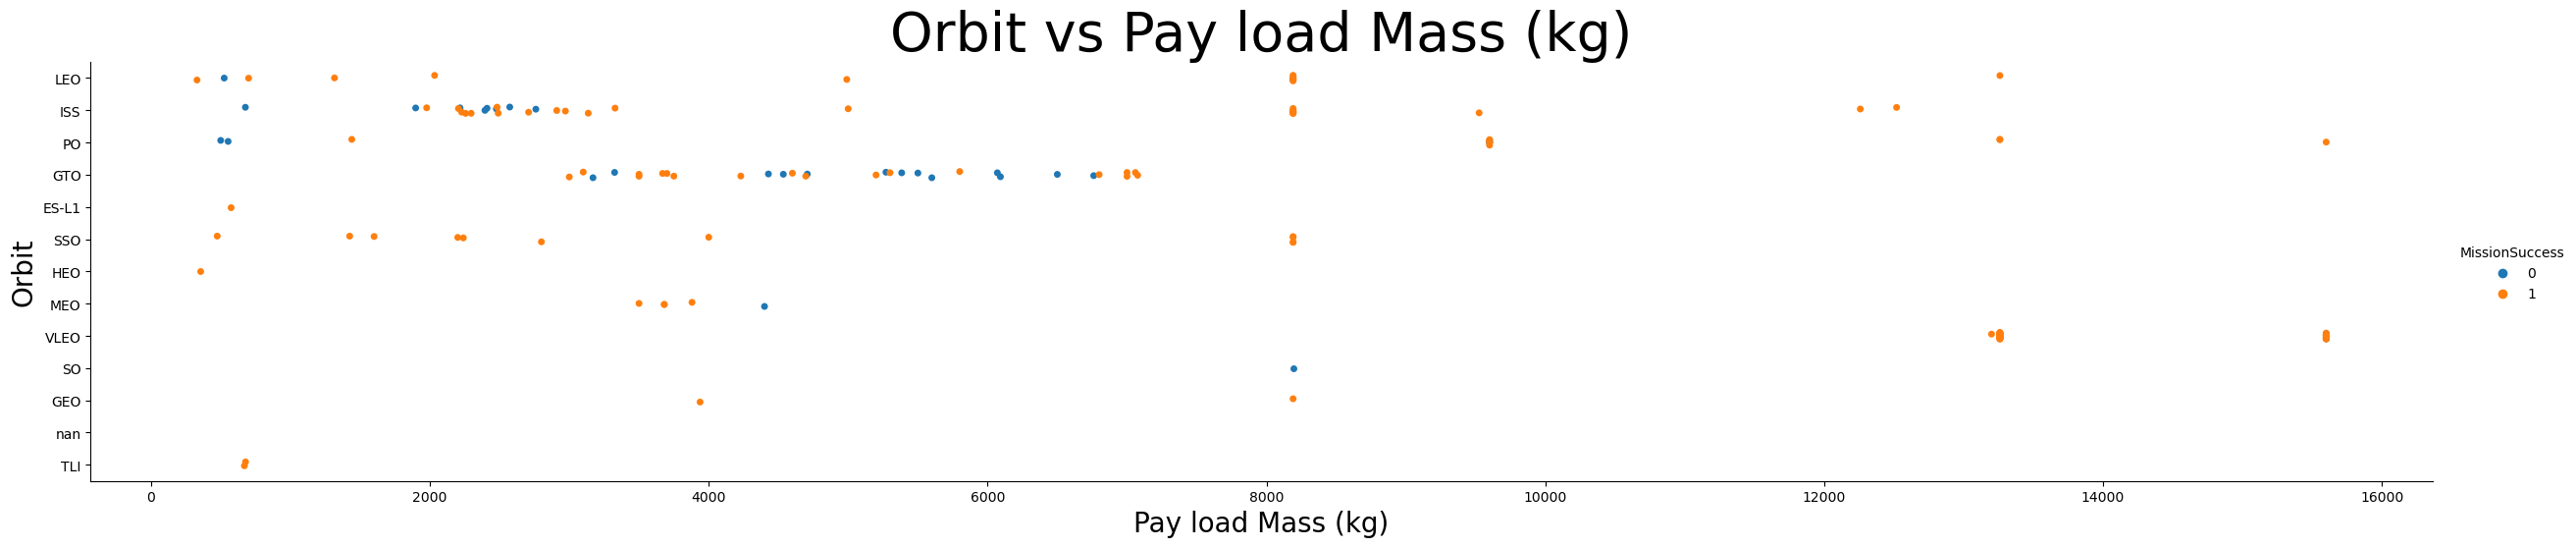

In [21]:
sns.catplot(data=df, x='PayloadMass',y='Orbit', hue='MissionSuccess', aspect=5)
plt.ylabel("Orbit",fontsize=20)
plt.xlabel("Pay load Mass (kg)",fontsize=20)
plt.title("Orbit vs Payload Mass (kg)", fontsize=40)
plt.show()

From the above plot, it looks like the majority of the missions were for small payloads under 8000 kg, which had various distributions of successful and unsuccessful missions.  It also seems that missions with the larger payloads resulted in a much higher success rate then the smaller payload missions. 

Interesting to note that for the most part, he orbits with the 100% success rate (ES-L1, GEO, HEO, SSO, TLI, VLEO), only had 1 or 2 missions that used those orbits. The only exception was the SSO orbit which had a grand total of 11 missions that used the orbit. 

In [24]:
df.groupby('Orbit')['MissionSuccess'].value_counts()

Orbit  MissionSuccess
ES-L1  1                  1
GEO    1                  2
GTO    1                 18
       0                 13
HEO    1                  1
ISS    1                 24
       0                  8
LEO    1                 12
       0                  2
MEO    1                  4
       0                  1
PO     1                 10
       0                  3
SO     0                  1
SSO    1                 11
TLI    1                  2
VLEO   1                 51
       0                  3
Name: MissionSuccess, dtype: int64

In [26]:
df2 = df.groupby(['Orbit', 'MissionSuccess']).agg({'MissionSuccess': 'sum'})
# Percentage by lambda and DataFrame.apply() method.
#df3 = df2.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
print(df2)

                      MissionSuccess
Orbit MissionSuccess                
ES-L1 1                            1
GEO   1                            2
GTO   0                            0
      1                           18
HEO   1                            1
ISS   0                            0
      1                           24
LEO   0                            0
      1                           12
MEO   0                            0
      1                            4
PO    0                            0
      1                           10
SO    0                            0
SSO   1                           11
TLI   1                            2
VLEO  0                            0
      1                           51


## Preparation for Machine Learning models
In order to use the categorical columns in our model, we need to convert the features to numerical columns. I can convert them all using the dummy

In [32]:
df.dtypes

FlightNumber        int64
Date               object
Booster            object
PayloadMass       float64
Orbit              object
Site               object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
MissionSuccess      int64
dtype: object

In [30]:

df[['Orbit', 'Site', 'LandingPad', 'Serial']].nunique()

Orbit         12
Site           3
LandingPad     6
Serial        62
dtype: int64

In [33]:
df_features=pd.get_dummies(data=df, columns=['Orbit', 'Site', 'LandingPad', 'Serial'])
df_features.head()

,FlightNumber,Date,Booster,PayloadMass,Outcome,Flights,GridFins,Reused,Legs,Block,...,Serial_B1060,Serial_B1061,Serial_B1062,Serial_B1063,Serial_B1067,Serial_B1069,Serial_B1071,Serial_B1072,Serial_B1073,Serial_B1077
4,1,2010-06-04,Falcon 9,8191.07911,None None,1,False,False,False,1.0,...,0,0,0,0,0,0,0,0,0,0
5,2,2012-05-22,Falcon 9,525.00000,None None,1,False,False,False,1.0,...,0,0,0,0,0,0,0,0,0,0
6,3,2013-03-01,Falcon 9,677.00000,None None,1,False,False,False,1.0,...,0,0,0,0,0,0,0,0,0,0
7,4,2013-09-29,Falcon 9,500.00000,False Ocean,1,False,False,False,1.0,...,0,0,0,0,0,0,0,0,0,0
8,5,2013-12-03,Falcon 9,3170.00000,None None,1,False,False,False,1.0,...,0,0,0,0,0,0,0,0,0,0
